In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [71]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


In [72]:
def extract_features(file_path):
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfccs

In [73]:
def get_emotion_from_filename(filename):
    # The emotion is encoded in the 3rd part of the filename: e.g., 03-01-05-01-02-01-12.wav -> '05' = angry
    emotion_code = filename.split("-")[2]
    return emotion_map.get(emotion_code)


In [96]:
allowed_emotions = {"happy", "sad", "angry", "neutral"}

def load_data(directory):
    features = []
    labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav") and file.startswith("03-02"):  # Songs
                file_path = os.path.join(root, file)
                emotion = get_emotion_from_filename(file)
                if emotion in allowed_emotions:
                    mfcc_list = extract_features(file_path, augment=True)
                    for feat in mfcc_list:
                        features.append(feat)
                        labels.append(emotion)

    return np.array(features), np.array(labels)

In [99]:
data_path = r"D:\PRC\project 2\speech emotion project"
X, y = load_data(data_path)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Total samples loaded: {len(X)}")
print(f"Labels: {set(y)}")

Total samples loaded: 1932
Labels: {np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('angry')}


In [100]:
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique emotion labels: {np.unique(y)}")

Feature matrix shape: (1932, 40)
Labels shape: (1932,)
Unique emotion labels: ['angry' 'happy' 'neutral' 'sad']


In [101]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

In [103]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (1545, 40), (1545, 4)
Test set shape: (387, 40), (387, 4)


In [104]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [105]:
input_shape = X_train.shape[1:]
num_classes = y_onehot.shape[1]

print(f"Input shape: {input_shape}")
print(f"Number of emotion classes: {num_classes}")

Input shape: (40, 1)
Number of emotion classes: 4


In [106]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation

model = Sequential()

# 1st Convolutional Block
model.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))  # reduced from 0.3

# 2nd Convolutional Block
model.add(Conv1D(64, 5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))  # reduced from 0.3

# Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # reduced from 0.3
model.add(Dense(num_classes, activation='softmax'))

In [107]:
# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 40, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 10, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,588 (232.77 KB)

 Trainable params: 59,204 (231.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [109]:
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

In [110]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Updated callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Training
history = model.fit(
    X_train, y_train,
    epochs=150,               # More epochs since dataset is larger
    batch_size=16,            # Smaller batch size to improve learning granularity
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stop, lr_schedule],
    shuffle=True,
    verbose=1
)

Epoch 1/150
91/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3735 - loss: 1.6581
Epoch 1: val_accuracy improved from -inf to 0.28682, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3764 - loss: 1.6435 - val_accuracy: 0.2868 - val_loss: 1.3511 - learning_rate: 0.0010
Epoch 2/150
86/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5656 - loss: 1.0182
Epoch 2: val_accuracy improved from 0.28682 to 0.35142, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5690 - loss: 1.0097 - val_accuracy: 0.3514 - val_loss: 1.2808 - learning_rate: 0.0010
Epoch 3/150
92/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7014 - loss: 0.7589
Epoch 3: val_accuracy improved from 0.35142 to 0.43411, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7013 - loss: 0.7582 - val_accuracy: 0.4341 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 4/150
92/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


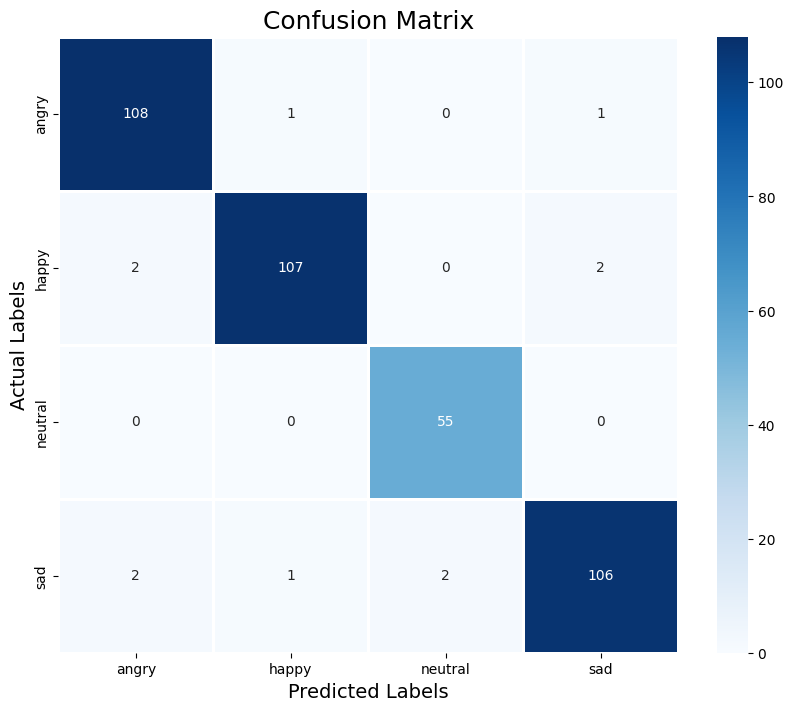

Classification Report:

              precision    recall  f1-score   support

       angry       0.96      0.98      0.97       110
       happy       0.98      0.96      0.97       111
     neutral       0.96      1.00      0.98        55
         sad       0.97      0.95      0.96       111

    accuracy                           0.97       387
   macro avg       0.97      0.98      0.97       387
weighted avg       0.97      0.97      0.97       387



In [111]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode integer labels back to emotion strings
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Confusion matrix as DataFrame
cm = confusion_matrix(y_true_labels, y_pred_labels)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linecolor='white', linewidths=1)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('Actual Labels', fontsize=14)
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

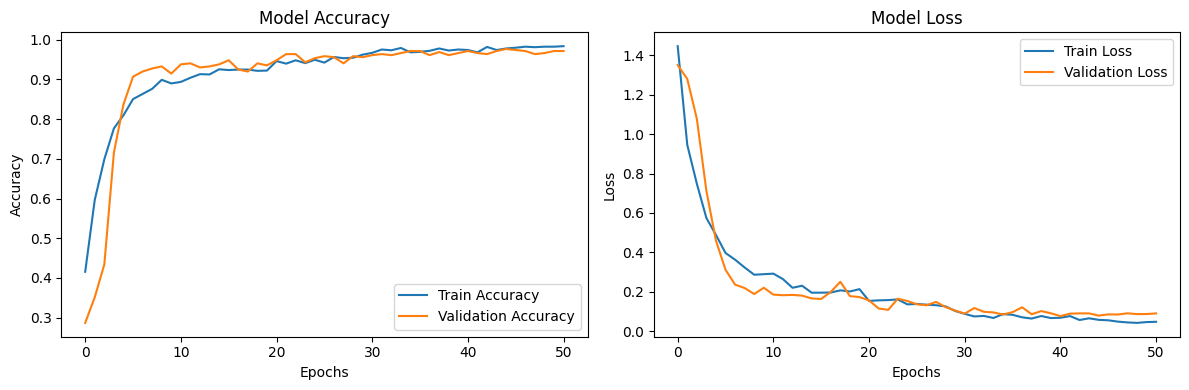

In [112]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [118]:
import os

folder_path = r"D:\PRC\project 2\speech emotion project"

# Look inside all subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".wav"):
            full_path = os.path.join(root, file)
            print("Found WAV file:", full_path)
            break
    else:
        continue
    break


Found WAV file: D:\PRC\project 2\speech emotion project\Actor_01\03-02-01-01-01-01-01.wav


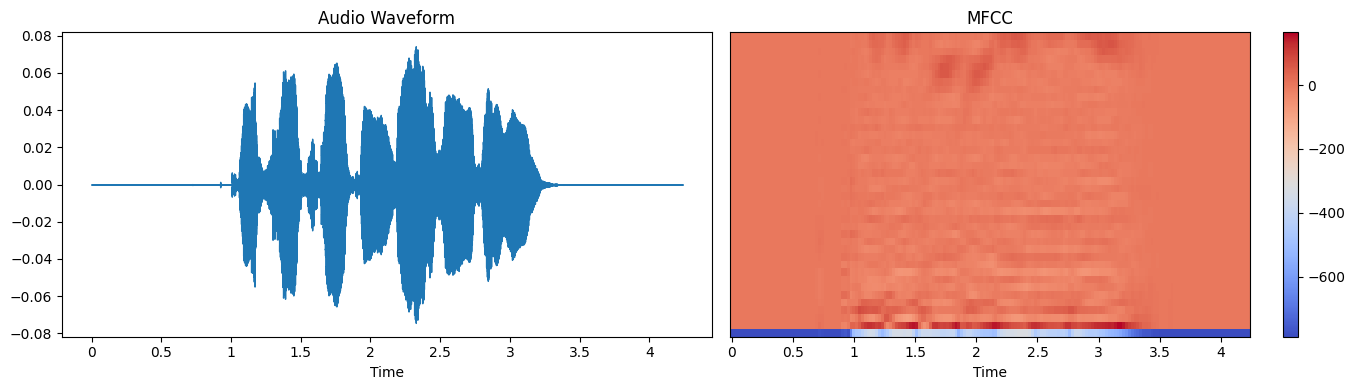

In [119]:
import librosa.display

# Pick one sample file to visualize (adjust path accordingly)
sample_file = r"D:\PRC\project 2\speech emotion project\Actor_01\03-02-01-01-01-01-01.wav"
signal, sr = librosa.load(sample_file)

plt.figure(figsize=(14, 4))

# Waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(signal, sr=sr)
plt.title("Audio Waveform")

# MFCC
plt.subplot(1, 2, 2)
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC")

plt.tight_layout()
plt.show()


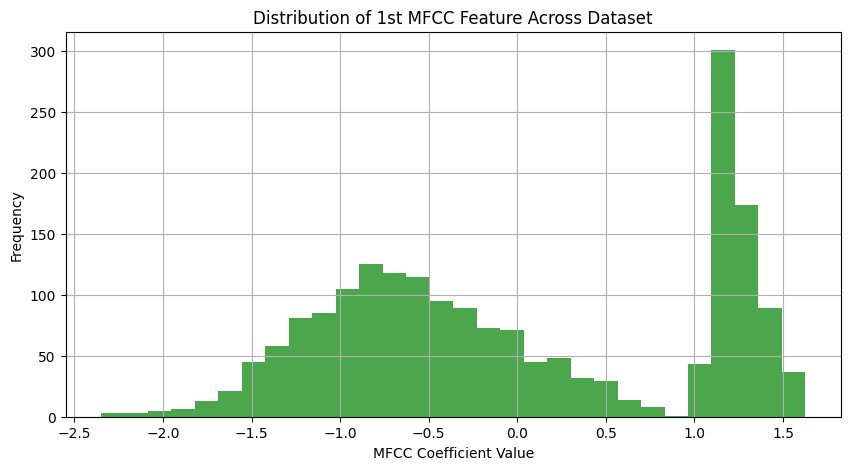

In [120]:
# Plot distribution of first MFCC feature across all samples
plt.figure(figsize=(10, 5))
plt.hist(X[:, 0], bins=30, alpha=0.7, color='green')
plt.title("Distribution of 1st MFCC Feature Across Dataset")
plt.xlabel("MFCC Coefficient Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [122]:
def predict_emotion(file_path):
    signal, sr = librosa.load(file_path, res_type='kaiser_fast')
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40).T, axis=0)
    mfcc_scaled = scaler.transform([mfcc])
    mfcc_scaled = mfcc_scaled[..., np.newaxis]  # Reshape for CNN

    prediction = model.predict(mfcc_scaled)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    print(f"Predicted Emotion: {predicted_label[0]}")

# Example:
predict_emotion(r"D:\PRC\project 2\speech emotion project\Actor_01\03-02-01-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: neutral


In [125]:
predict_emotion(r"D:\PRC\project 2\speech emotion project\Actor_01\03-02-02-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Emotion: happy


In [126]:
predict_emotion(r"D:\PRC\project 2\speech emotion project\Actor_02\03-02-03-01-01-01-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Emotion: happy


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


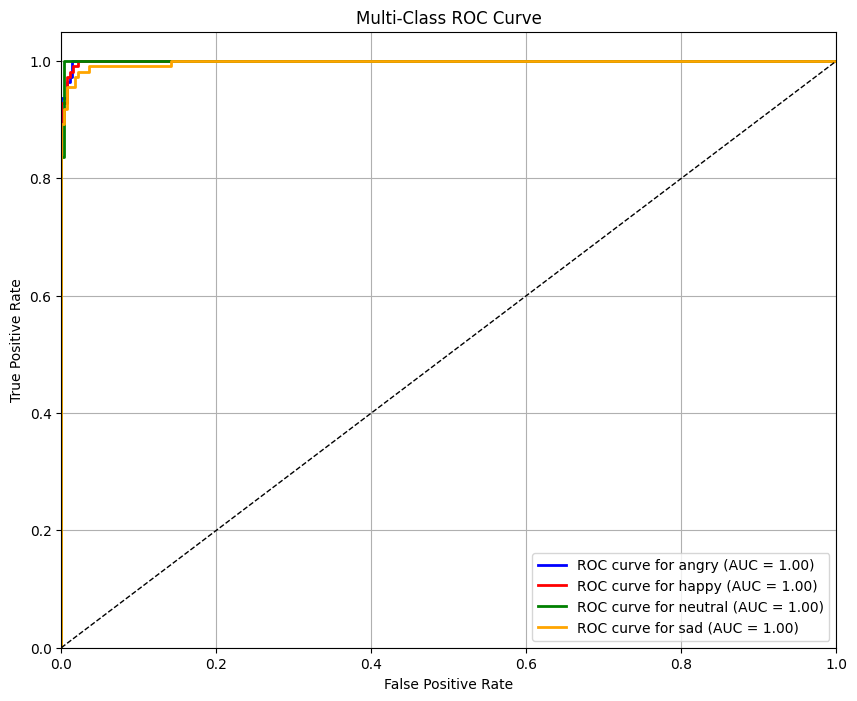

In [127]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output (One-hot if not already)
y_test_bin = y_test  # Already one-hot from your earlier encoding
y_score = model.predict(X_test)

# Classes
class_names = label_encoder.classes_
n_classes = len(class_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()